In [27]:
import pandas as pd
import numpy as np
import gc

import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
import scipy
import lightgbm as lgb

In [2]:
used_cols = ['item_id', 'user_id']

train = pd.read_csv('../input/train.csv', usecols=used_cols)
train_active = pd.read_csv('../input/train_active.csv', usecols=used_cols)
test = pd.read_csv('../input/test.csv', usecols=used_cols)
test_active = pd.read_csv('../input/test_active.csv', usecols=used_cols)

train_periods = pd.read_csv('../input/periods_train.csv', parse_dates=['date_from', 'date_to'])
test_periods = pd.read_csv('../input/periods_test.csv', parse_dates=['date_from', 'date_to'])

train.head()

,item_id,user_id
0,b912c3c6a6ad,e00f8ff2eaf9
1,2dac0150717d,39aeb48f0017
2,ba83aefab5dc,91e2f88dd6e3
3,02996f1dd2ea,bf5cccea572d
4,7c90be56d2ab,ef50846afc0b


In [3]:
all_samples = pd.concat([
    train,
    train_active,
    test,
    test_active
]).reset_index(drop=True)
all_samples.drop_duplicates(['item_id'], inplace=True)

del train_active
del test_active
gc.collect()

21

In [4]:
all_samples.shape

(19465016, 2)

In [5]:
all_periods = pd.concat([
    train_periods,
    test_periods
])

del train_periods
del test_periods
gc.collect()

all_periods.head()

,item_id,activation_date,date_from,date_to
0,8f5caef7afb0,2017-02-14,2017-03-15,2017-03-16
1,66218ff526d1,2017-02-16,2017-03-15,2017-03-18
2,b237d9539b21,2017-03-01,2017-03-15,2017-03-28
3,80bf58082ad3,2017-03-19,2017-03-19,2017-03-28
4,67a9944a7373,2017-03-14,2017-03-15,2017-03-28


In [6]:
all_periods['days_up'] = all_periods['date_to'].dt.dayofyear - all_periods['date_from'].dt.dayofyear

In [7]:
gp = all_periods.groupby(['item_id'])[['days_up']]

gp_df = pd.DataFrame()
gp_df['days_up_sum'] = gp.sum()['days_up']
gp_df['times_put_up'] = gp.count()['days_up']
gp_df.reset_index(inplace=True)
gp_df.rename(index=str, columns={'index': 'item_id'})

gp_df.head()

,item_id,days_up_sum,times_put_up
0,00000077ff21,13,1
1,000002c54018,6,1
2,000005570503,1,1
3,0000060018e6,6,1
4,000006497719,19,2


In [8]:
all_periods.drop_duplicates(['item_id'], inplace=True)
all_periods = all_periods.merge(gp_df, on='item_id', how='left')
all_periods.head()

,item_id,activation_date,date_from,date_to,days_up,days_up_sum,times_put_up
0,8f5caef7afb0,2017-02-14,2017-03-15,2017-03-16,1,17,4
1,66218ff526d1,2017-02-16,2017-03-15,2017-03-18,3,18,3
2,b237d9539b21,2017-03-01,2017-03-15,2017-03-28,13,19,2
3,80bf58082ad3,2017-03-19,2017-03-19,2017-03-28,9,17,4
4,67a9944a7373,2017-03-14,2017-03-15,2017-03-28,13,18,3


In [9]:
all_periods = all_periods.merge(all_samples, on='item_id', how='left')
all_periods.head()

,item_id,activation_date,date_from,date_to,days_up,days_up_sum,times_put_up,user_id
0,8f5caef7afb0,2017-02-14,2017-03-15,2017-03-16,1,17,4,e292cce69842
1,66218ff526d1,2017-02-16,2017-03-15,2017-03-18,3,18,3,a326c04a24ec
2,b237d9539b21,2017-03-01,2017-03-15,2017-03-28,13,19,2,06d275498a56
3,80bf58082ad3,2017-03-19,2017-03-19,2017-03-28,9,17,4,831c8c4a622c
4,67a9944a7373,2017-03-14,2017-03-15,2017-03-28,13,18,3,248102e50d79


In [10]:
gp = all_periods.groupby(['user_id'])[['days_up_sum', 'times_put_up']].mean().reset_index() \
    .rename(index=str, columns={
        'days_up_sum': 'avg_days_up_user',
        'times_put_up': 'avg_times_up_user'
    })
gp.head()

,user_id,avg_days_up_user,avg_times_up_user
0,00000077ff21,12.5,2.00
1,000006497719,19.0,2.00
2,00000b4d72f6,3.0,1.00
3,00000d642d7e,13.0,1.00
4,0000126b80a4,12.0,1.75


In [11]:
n_user_items = all_samples.groupby(['user_id'])[['item_id']].count().reset_index() \
    .rename(index=str, columns={
        'item_id': 'n_user_items'
    })
gp = gp.merge(n_user_items, on='user_id', how='outer')

gp.head()

,user_id,avg_days_up_user,avg_times_up_user,n_user_items
0,00000077ff21,12.5,2.00,2
1,000006497719,19.0,2.00,1
2,00000b4d72f6,3.0,1.00,1
3,00000d642d7e,13.0,1.00,2
4,0000126b80a4,12.0,1.75,8


In [14]:
gp.to_pickle('../input/aggregated_features.pkl')

In [15]:
del all_samples
del all_periods
del train
del test

gc.collect()

2084

In [ ]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

train = train.merge(gp, on='user_id', how='left')
test = test.merge(gp, on='user_id', how='left')

agg_cols = list(gp.columns)[1:]

del gp
gc.collect()

In [19]:
train_d2v = pd.read_pickle('../input/train_d2v.pkl')
test_d2v = pd.read_pickle('../input/test_d2v.pkl')
train = pd.concat([train, train_d2v], axis=1)
test = pd.concat([test, test_d2v], axis=1)
del train_d2v, test_d2v
gc.collect()

1251

In [37]:
for df in [train, test]:

    df['weekday'] = pd.to_datetime(df['activation_date']).dt.weekday
    
#     df['title_date'] = df['title'].astype(str).str.extract('((19|20)\d{2})')
#     df['title_date'] = df['title_date'].fillna(-999).astype(float)

    df['description'].fillna('', inplace=True)
#     df['title'].fillna('', inplace=True)
    df['title_numbers'] = df['title'].str.extract("(\d+)", expand=False)
    df['title_numbers'] = df['title_numbers'].fillna(-999).astype(np.float16)
    
    for col in ['description', 'title']:
        df['num_words_' + col] = df[col].apply(lambda comment: len(comment.split()))
        df['num_unique_words_' + col] = df[col].apply(lambda comment: len(set(w for w in comment.split())))
        
        
        df['num_words' + col] = df[col].apply(lambda comment: len(str(comment).split())).astype(np.uint32)
        df['num_unique_words' + col] = df[col].apply(lambda comment: len(set(w for w in str(comment).split()))).astype(np.uint32)
        df['char_count'+ col] = df[col].apply(lambda x: len(x) if x is not np.nan else 0)
        df['word_count'+ col] = df[col].apply(lambda x: len(x.split())if x is not np.nan else 0).astype(np.uint32)
        df['punctuation_count'+ col] = df[col].fillna('').apply(lambda x: sum([1 for i in x if i in string.punctuation])).astype(np.uint32)
        
        df['upper_case_count'+ col] = df[col].fillna('').apply(lambda x: sum(c.isupper() for c in x)).astype(np.uint32)
        df['lower_case_count'+ col] = df[col].fillna('').apply(lambda x: sum(c.islower() for c in x)).astype(np.uint32)
        df['digit_count'+ col] = df[col].fillna('').apply(lambda x: sum(c.isdigit() for c in x)).astype(np.uint32)
        df['space_count'+ col] = df[col].fillna('').apply(lambda x: sum(c.isspace() for c in x)).astype(np.uint32)
        df['newline_count'+ col] = df[col].fillna('').apply(lambda x: x.count('\n') if x is not np.nan else 0).astype(np.uint32)
        
        df['num_symbols'+ col] = df[col].fillna('').apply(lambda x: sum(x.count(w) for w in '!@#$%^&*()_+{}[]:";<>?1234567890x')).astype(np.uint32)
        df['mean_word_len'+ col] = df[col].fillna('').apply(lambda x: np.mean([len(w) for w in x.split()]))
        df['caps_vs_length'+ col] = df['upper_case_count'+ col] / df['char_count'+ col]
        df['words_vs_unique'+ col] = df['num_unique_words'+ col] / df['num_words'+ col]
        
    

    df['words_vs_unique_title'] = df['num_unique_words_title'] / df['num_words_title'] * 100
    df['words_vs_unique_description'] = df['num_unique_words_description'] / df['num_words_description'] * 100
    
    df['city'] = df['region'] + '_' + df['city']
    df['num_desc_punct'] = df['description'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    
    df.loc[:,'image_item_n'] = df.groupby(['image_top_1','item_seq_number']).user_id.transform('nunique')
    df.loc[:,'image_city_n'] = df.groupby(['city','image_top_1']).user_id.transform('nunique')
    df.loc[:,'image_region_n'] = df.groupby(['region','image_top_1']).user_id.transform('nunique')
    df.loc[:,'image_categoryname_n'] = df.groupby(['category_name','image_top_1']).user_id.transform('nunique')
    df.loc[:,'image_param2_n'] = df.groupby(['image_top_1','param_2']).user_id.transform('nunique')
    df.loc[:,'image_parentcategoryname_n'] = df.groupby(['parent_category_name','image_top_1']).user_id.transform('nunique')
    df.loc[:,'image_usertype_n'] = df.groupby(['image_top_1','user_type']).user_id.transform('nunique')
    df.loc[:,'image_param1_n'] = df.groupby(['image_top_1','param_1']).user_id.transform('nunique')
    df.loc[:,'image_param3_n'] = df.groupby(['image_top_1','param_3']).user_id.transform('nunique')

    
    df["price"] = np.log(df["price"]+10)
    df["price"].fillna(-999,inplace=True)
    df["image_top_1"].fillna(-999,inplace=True)

C:\Users\hello\Anaconda3\envs\dlwin36\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [38]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=10,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [39]:
for col in [    
    'image_top_1',
'param_1',
'param_2',
'param_3',
'city',
'region',
'category_name',
'parent_category_name',
'user_type',
    'item_seq_number'
]:
    trn, tst = target_encode(train[col], 
                         test[col], 
                         target=train.deal_probability, 
                         min_samples_leaf=0,
                         smoothing=10,
                         noise_level=0.01)
    train[col+'_cat_enc'] = trn
    test[col+'_cat_enc'] = tst

In [40]:
for col in ['image_top_1',
'param_1',
'param_2',
'param_3',
'city',
'region',
'category_name',
'parent_category_name',
'user_type',
    'item_seq_number'
]:
    trn, tst = target_encode(train[col], 
                         test[col], 
                         target=train.price, 
                         min_samples_leaf=0,
                         smoothing=5,
                         noise_level=0.0)
    train[col+'_price'] = trn
    test[col+'_price'] = tst

In [53]:
target = 'deal_probability'

categorical = [
    'image_top_1',  
    'param_1', 'param_2', 'param_3', 
    'city', 'region', 'category_name', 'parent_category_name', 'user_type'
]

for feature in categorical:
    print(f'Transforming {feature}...')
    encoder = LabelEncoder()
    train[feature].fillna(-999,inplace=True)
    test[feature].fillna(-999,inplace=True)
    encoder.fit(train[feature].append(test[feature]).astype(str))
    
    train[feature+'_le'] = encoder.transform(train[feature].astype(str))
    test[feature+'_le'] = encoder.transform(test[feature].astype(str))

In [55]:
train.columns.tolist()

['item_id',
 'user_id',
 'region',
 'city',
 'parent_category_name',
 'category_name',
 'param_1',
 'param_2',
 'param_3',
 'title',
 'description',
 'price',
 'item_seq_number',
 'activation_date',
 'user_type',
 'image',
 'image_top_1',
 'deal_probability',
 'avg_days_up_user',
 'avg_times_up_user',
 'n_user_items',
 'd2v_des_0',
 'd2v_des_1',
 'd2v_des_2',
 'd2v_des_3',
 'd2v_des_4',
 'd2v_des_5',
 'd2v_des_6',
 'd2v_des_7',
 'd2v_des_8',
 'd2v_des_9',
 'd2v_des_10',
 'd2v_des_11',
 'd2v_des_12',
 'd2v_des_13',
 'd2v_des_14',
 'd2v_des_15',
 'd2v_des_16',
 'd2v_des_17',
 'd2v_des_18',
 'd2v_des_19',
 'd2v_des_20',
 'd2v_des_21',
 'd2v_des_22',
 'd2v_des_23',
 'd2v_des_24',
 'd2v_des_25',
 'd2v_des_26',
 'd2v_des_27',
 'd2v_des_28',
 'd2v_des_29',
 'd2v_des_30',
 'd2v_des_31',
 'd2v_des_32',
 'd2v_des_33',
 'd2v_des_34',
 'd2v_des_35',
 'd2v_des_36',
 'd2v_des_37',
 'd2v_des_38',
 'd2v_des_39',
 'd2v_des_40',
 'd2v_des_41',
 'd2v_des_42',
 'd2v_des_43',
 'd2v_des_44',
 'd2v_des_45',


In [54]:
target = 'deal_probability'

predictors = train.columns.tolist()

remove_features = ['item_id','user_id','title','description','image','activation_date','deal_probability'] + categorical 

predictors = list(set(predictors) - set(remove_features))

categorical = ['param_1_le', 'param_2_le', 'region_le', 'category_name_le', 
               'parent_category_name_le', 'user_type_le']
print(len(predictors))

180


In [73]:
rounds = 10000
early_stop_rounds = 50
lgbm_params = {
    'objective' : 'poisson',
    'poisson_max_delta_step' : 2,
    
    
    'boosting_type': 'gbdt',
#     'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 12,
    'max_bin' : 63,
    'num_leaves': 270,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.7,
#     'bagging_freq': 2,
    
    'is_sparse' : False,
    'learning_rate' : 0.021,
    'verbosity' : -1,
    
#     'device' : "gpu",
#     'gpu_platform_id' : 0,
#     'gpu_device_id' : 2,
#     'num_threads' : 1,
    
#     'gpu_use_dp' : True,
#     
    'num_threads' : 6,

}

In [57]:
train.shape

(1503424, 196)

In [68]:
import lightgbm as lgb

In [74]:
train_index, valid_index = train_test_split(np.arange(len(train)), test_size=0.1, random_state=42)

x_train = train.loc[train_index, predictors]
y_train = train.loc[train_index, target]

x_valid = train.loc[valid_index, predictors]
y_valid = train.loc[valid_index, target]

x_test = test.loc[:, predictors]

dtrain = lgb.Dataset(x_train, label=y_train,
                     feature_name=predictors, 
                     categorical_feature=categorical)
dvalid = lgb.Dataset(x_valid, label=y_valid,
                     feature_name=predictors, 
                     categorical_feature=categorical)

In [75]:
evals_result = {}
model = lgb.train(lgbm_params, dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train', 'valid'],
                  num_boost_round=rounds, 
                  early_stopping_rounds=early_stop_rounds, 
                  verbose_eval=500)

C:\Users\hello\Anaconda3\envs\dlwin36\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\hello\Anaconda3\envs\dlwin36\lib\site-packages\lightgbm\basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 50 rounds.
[500]	train's rmse: 0.226996	valid's rmse: 0.228038
[1000]	train's rmse: 0.221574	valid's rmse: 0.223615
[1500]	train's rmse: 0.219245	valid's rmse: 0.222311
[2000]	train's rmse: 0.21744	valid's rmse: 0.22159
[2500]	train's rmse: 0.215858	valid's rmse: 0.221106
[3000]	train's rmse: 0.214383	valid's rmse: 0.220768
[3500]	train's rmse: 0.213002	valid's rmse: 0.220529
[4000]	train's rmse: 0.211675	valid's rmse: 0.220351
[4500]	train's rmse: 0.210404	valid's rmse: 0.220212
[5000]	train's rmse: 0.209216	valid's rmse: 0.220121
[5500]	train's rmse: 0.20805	valid's rmse: 0.220034
[6000]	train's rmse: 0.206925	valid's rmse: 0.219972
[6500]	train's rmse: 0.205814	valid's rmse: 0.219926
[7000]	train's rmse: 0.2047	valid's rmse: 0.219878
[7500]	train's rmse: 0.203617	valid's rmse: 0.219842
[8000]	train's rmse: 0.202529	valid's rmse: 0.219808
[8500]	train's rmse: 0.201449	valid's rmse: 0.219776
[9000]	train's rmse: 0.200387	valid's rmse:

Text(0.5,1,'Light GBM Feature Importance')

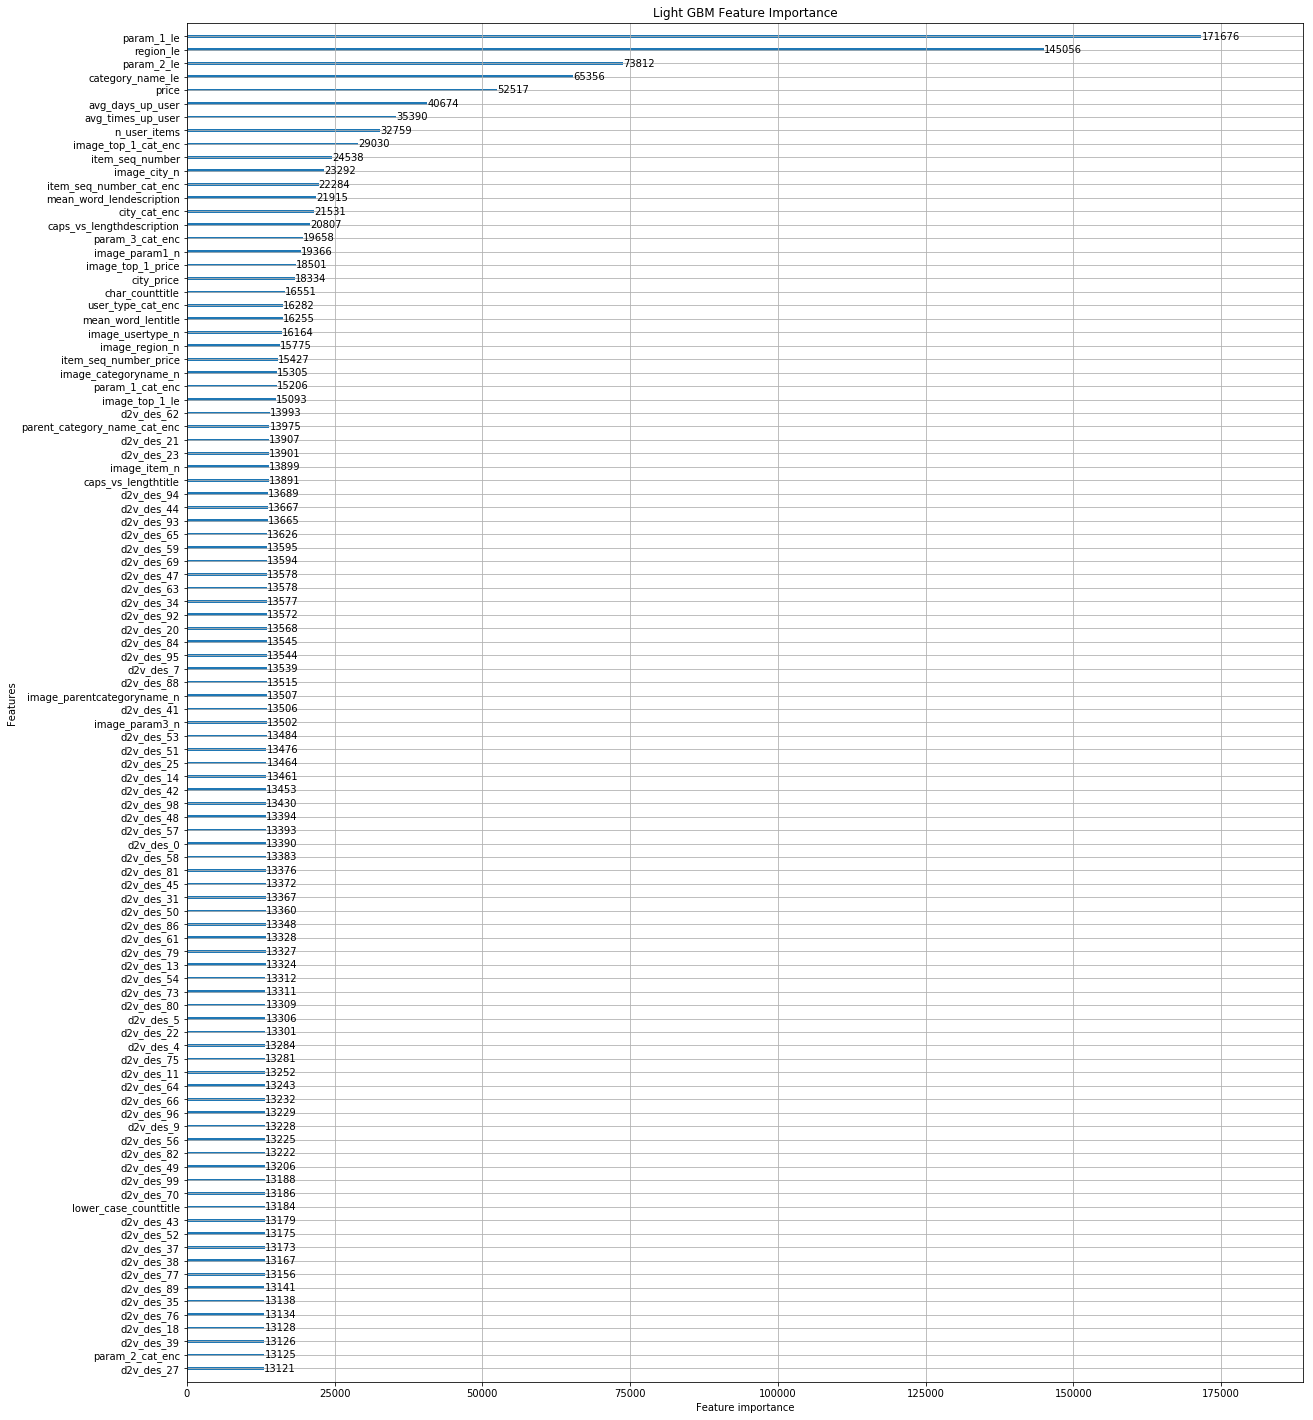

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(20, 25))
lgb.plot_importance(model, max_num_features=100, ax=ax)
plt.title("Light GBM Feature Importance")

In [81]:
subm = pd.read_csv('../input/sample_submission.csv')
subm['deal_probability'] = np.clip(model.predict(x_test), 0, 1)
subm.to_csv('submission_dv2.csv', index=False)

In [83]:
train['weekday'].value_counts()

20    115190
27    114863
19    114416
26    113513
28    112885
21    110535
22    109813
15    108615
23    106544
16    106168
17     98773
18     97554
24     97351
25     97104
29        87
2          3
1          3
30         3
3          2
7          1
31         1
Name: weekday, dtype: int64